In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
#구글 드라이브 연동하기
#구글 드라이브에 데이터를 올린 후 사용할 경우에만 실행
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [4]:
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [5]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape 

(10886, 16)

In [6]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [7]:
#범주형 feature의 type을 category로 변경
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

In [8]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"
                ]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [9]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [10]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [11]:
label_name = 'count'

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [12]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

  if convertExp:
    predicted_values = np.exp(predicted_values),
    actual_values = np.exp(actual_values)

    #넘파이로 배열 형태로 바꿔줌
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    #예측값과 실제 값에 1을 더하고 로그 씌워줌
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values +1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)

    #평균
    mean_difference = difference.mean()

    #다시 루트 씌움
    score = np.sqrt(mean_difference)

    return score

# 선형회귀 모델 Linear Regression Model

In [13]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=DeprecationWarning)

#선형회귀 모델을 초기화
lModel = LinearRegression()

#모델을 학습시킴
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

#예측하고 정확도 평가
preds = lModel.predict(X_train)
print('RMSLE Value For Linear Regression: ', rmsle(np.exp(y_train_log), np.exp(preds), False))

RMSLE Value For Linear Regression:  None


# 릿지 Regularization Model - Ridge

In [16]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000], 'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_, 
                            ridge_params_,
                            scoring = rmsle_scorer,
                            cv=5)
y_train_log = np.log1p(y_train)
grid_ridge_m.fit(X_train, y_train_log)
preds = grid_ridge_m.predict(X_train)
print(grid_ridge_m.best_params_)
print('RMSLE Value for Ridge Regression : ', rmsle(np.exp(y_train_log), np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value for Ridge Regression :  None


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005416,0.000901,0.002646,0.000158,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.003138,-0.906726,-1.029928,-1.016631,-0.982313,-0.987747,0.043461,1
1,0.004894,0.000065,0.002673,0.000226,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.003140,-0.906726,-1.029928,-1.016630,-0.982315,-0.987748,0.043461,2
2,0.005255,0.000763,0.005800,0.006507,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.003167,-0.906727,-1.029927,-1.016621,-0.982331,-0.987755,0.043461,3
3,0.005139,0.000244,0.002670,0.000138,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.003196,-0.906728,-1.029926,-1.016612,-0.982349,-0.987762,0.043461,4
4,0.004833,0.000106,0.002533,0.000029,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.003226,-0.906729,-1.029925,-1.016602,-0.982366,-0.987770,0.043460,5


In [18]:
df['alpha'] = df['params'].apply(lambda x:x['alpha'])
df['rmsle'] = df['mean_test_score'].apply(lambda x:-x)
df[['alpha', 'rmsle']].head()

,alpha,rmsle
0,0.01,0.987747
1,0.10,0.987748
2,1.00,0.987755
3,2.00,0.987762
4,3.00,0.987770


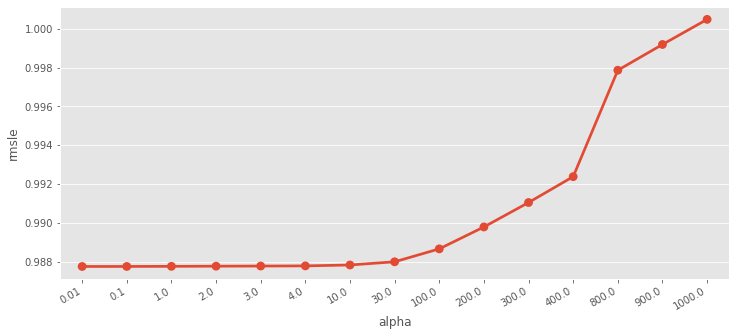

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x='alpha', y='rmsle', ax=ax)

# 라쏘 Regularization Model - Lasso

In [24]:
lasso_m_ = Lasso()

alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params_ = { 'max_iter':[3000], 'alpha':alpha}

grid_lasso_m = GridSearchCV(lasso_m_, lasso_params_, scoring = rmsle_scorer, cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit(X_train, y_train_log)
preds = grid_lasso_m.predict(X_train)
print(grid_lasso_m.best_params_)
print("RMSLE Value for Lasso Regression: ", rmsle(np.exp(y_train_log), np.exp(preds), False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df['alpha'] = df['params'].apply(lambda x:x['alpha'])
df['rmsle'] = df['mean_test_score'].apply(lambda x:-x)

df[['alpha', 'rmsle']].head()

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value for Lasso Regression:  None


,alpha,rmsle
0,10.000000,1.397124
1,1.000000,1.071947
2,0.500000,1.062110
3,0.333333,1.060815
4,0.250000,1.061139
